<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Unet_attention_IDrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to one attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(1, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [4]:
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [3, 6, 12, 24, 48]
    
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])#8*8*48
    
    u1 = up_block(bn, c4, f[3]) #8 - > 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [5]:
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2

## Train data read

In [6]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))

print(len(train_data))

54


In [7]:

# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [8]:
train_data_gt[3][0][-9:-7]

'03'

In [9]:
train_data[2][-6:-4]

'03'

## Test data read

In [18]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))

In [31]:
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


(2848, 4288, 4)


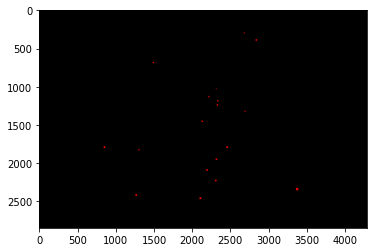

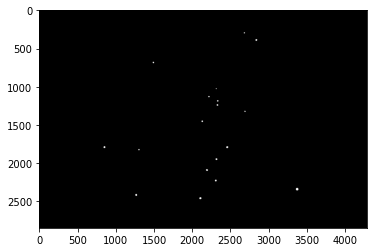

(2848, 4288)


In [10]:
print(imread(train_data_gt[0][0]).shape)
plt.imshow(imread(train_data_gt[0][0]),cmap='gray')
plt.show()
img = cv2.cvtColor(imread(train_data_gt[0][0]), cv2.COLOR_BGRA2BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')
plt.show()
print(img.shape)

In [35]:
np.max(img),np.min(img),np.max(imread(train_data[0]))

(29, 0, 255)

## Data Generator

In [11]:
def data_gen(x_path_list,y_path_list,batch_size=3):
  """
  Return batches of input image and segmentaion mask 
  """  
  train_batch = np.zeros(shape = (3, 512, 512, 3));
  
  train_label = np.zeros(shape = (3, 512, 512, 1));
  counter=0
  skipped=0
  while True :
    
    #image
    train_batch[0, :, :,:] = resize(imread(x_path_list[counter+skipped]), (512, 512))
    #label
    if x_path_list[counter+skipped][-6:-4]==y_path_list[counter][-9:-7]:
      img = cv2.cvtColor(imread(y_path_list[counter]), cv2.COLOR_BGRA2BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      train_label[0, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
      
      #flip
      train_batch[1, :, :,:]=np.flip(train_batch[0, :, :,:],axis=1)
      train_label[1, :, :,:]=np.flip(train_label[0, :, :,:],axis=1)
      #rotate
      train_batch[2, :, :,:]=np.rot90(np.rot90(train_batch[0, :, :,:]))
      train_label[2, :, :,:]=np.rot90(np.rot90(train_label[0, :, :,:]))
      train_batch/=255
      train_label[:,:,:,0]  = (train_label[:,:,:,0] - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
      mask = train_label[:,:,:,:] > 0.3
      train_label[mask] = 1.0
      train_label[~mask] = 0.0
      yield train_batch,train_label
      counter+=1
    else:
      skipped+=1
      
    
    if counter>=len(y_path_list):
      counter=0
      skipped=0
gen=data_gen(train_data,train_data_gt[0])

## Model

In [12]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

In [13]:
from keras.callbacks import ReduceLROnPlateau

In [14]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
image_size = 512
epochs = 100
batch_size = 2
models=[]
histories=[]
for i,segment in enumerate(segs):
  print(i," ", segment)
  rate=0.001
  opt=keras.optimizers.Adam(learning_rate = rate)
  model = UNet()
  model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.AUC()])  
  early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=5)
  rlrop=ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)
  gen=data_gen(train_data,train_data_gt[i])
  hist = model.fit_generator(gen, steps_per_epoch=len(train_data_gt[i]), epochs = 100, verbose = 1, callbacks=[early_stopping,rlrop], shuffle = True)
  models.append(model)
  histories.append(hist)

0   1. Microaneurysms
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
54/54 [==============================] - 72s 1s/step - loss: 0.9968 - auc: 0.6386
Epoch 2/100
54/54 [==============================] - 19s 343ms/step - loss: 0.9964 - auc: 0.6987
Epoch 3/100
54/54 [==============================] - 19s 344ms/step - loss: 0.9962 - auc: 0.7192
Epoch 4/100
54/54 [==============================] - 18s 341ms/step - loss: 0.9959 - auc: 0.7479
Epoch 5/100
54/54 [==============================] - 18s 337ms/step - loss: 0.9952 - auc: 0.7829
Epoch 6/100
54/54 [==============================] - 18s 336ms/step - loss: 0.9937 - auc: 0.8331
Epoch 7/100
54/54 [==============================] - 18s 337ms/step - loss: 0.9908 - auc: 0.8767
Epoch 8/100
54/54 [==============================] - 18s 339ms/step - loss: 0.9855 - auc: 0.8901
Epoch 9/100
54/54 [==============================] - 18s 337ms/step - loss: 0.9748 - auc: 0.8857
Epoch 10/100
54/54 [============

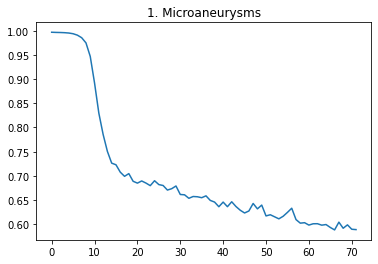

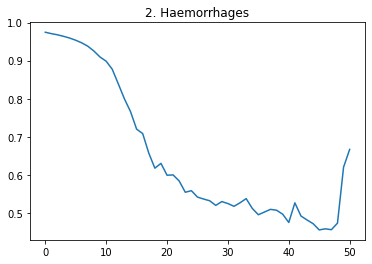

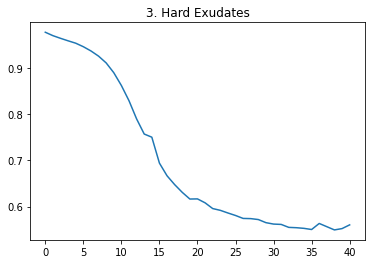

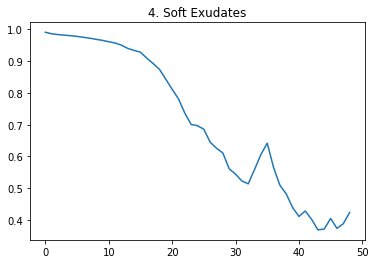

In [15]:
i=0
for hist in histories:
    plt.plot(hist.history['loss'])
    plt.title(segs[i])
    plt.show()
    i+=1

In [16]:
train_batch = np.zeros(shape = (len(train_data), 512, 512, 3));
for file_index in range(0,len(train_data)):
    # image
    train_batch[file_index, :, :,:] = resize(imread(train_data[file_index]), (512, 512))
train_batch /=255

(512, 512, 1)
1. Microaneurysms


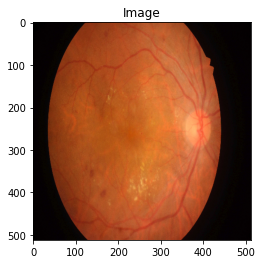

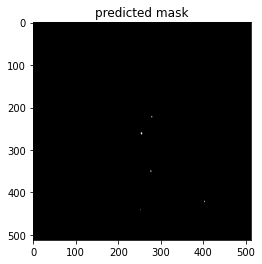

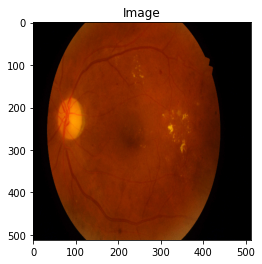

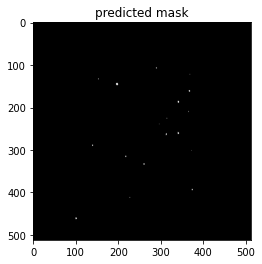

(512, 512, 1)
2. Haemorrhages


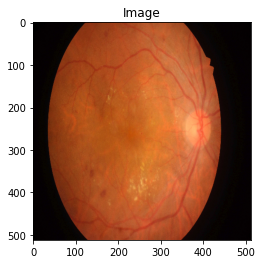

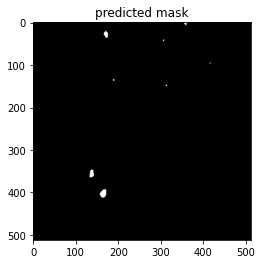

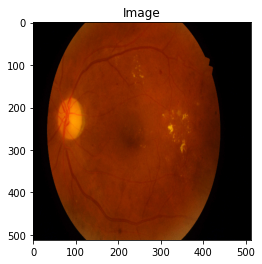

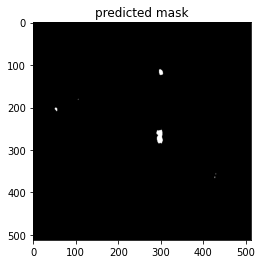

(512, 512, 1)
3. Hard Exudates


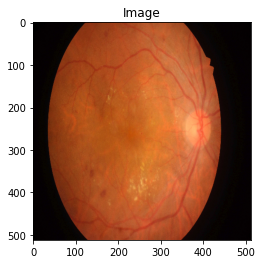

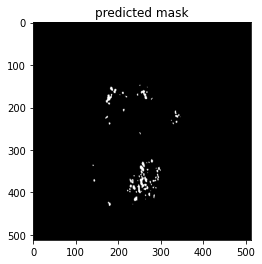

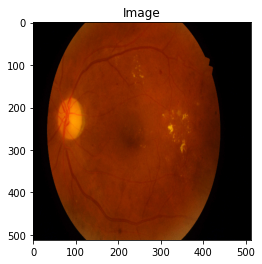

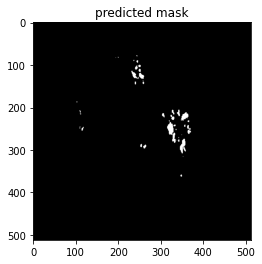

(512, 512, 1)
4. Soft Exudates


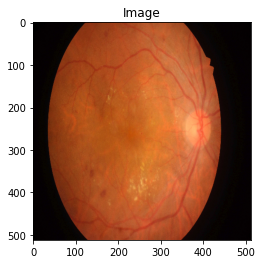

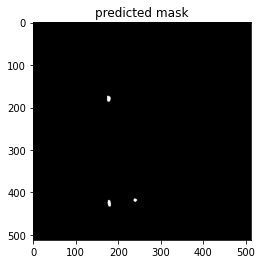

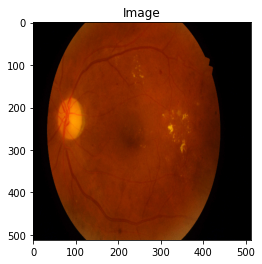

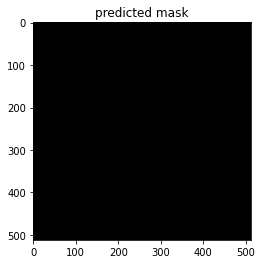

In [68]:
j=0
pred_tr_labels=[]
for model in models:
  predicted_train_label = model.predict(train_batch);
  print(predicted_train_label[0].shape)
  print(segs[j])
  j+=1
  pred_tr_labels.append(predicted_train_label)
  for i in range(2):
      plt.imshow(train_batch[i,:,:,:])
      plt.title("Image")
      plt.show()
      plt.imshow(np.squeeze(predicted_train_label[i,:,:,:],axis=2),cmap='gray')
      plt.title("predicted mask")
      plt.show()
      #plt.imshow(np.squeeze(train_label[i,:,:,:],axis=2),cmap='gray')
      #plt.title("actual mask")
      #plt.show()

## Test data

In [54]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
test_labels_ls=[]


for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    test_batch[file_index, :, :,:] = resize(imread(test_data[int(file_index)]), (512, 512))

# Normalize
test_batch  = test_batch/255


# labels
for seg in test_data_gt:
    # here i am initializing it to 27 size though original mask no may be diff
    test_label = np.zeros(shape = (len(test_data), 512, 512, 1));
    # but i am filing the test_label serially ie if one mask is not there i am not leaving that place balnk but filing the next mask in its place
    for file_index in range(0,len(seg)):  
      img = cv2.cvtColor(imread(seg[file_index]), cv2.COLOR_BGRA2BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      test_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
    # scale to 0-1
    test_label[:,:,:,0]  = (test_label[:,:,:,0] - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)
    # binarize the masks
    mask = test_label[:,:,:,:] > 0.3
    test_label[mask] = 1.0
    test_label[~mask] = 0.0
    # append masks to common list
    test_labels_ls.append(test_label)




print(test_batch.shape)
print(test_labels_ls[0].shape)

(27, 512, 512, 3)
(27, 512, 512, 1)


In [63]:
# seperate indicies for soft exdutes
ind=[]
for i in range(len(test_data_gt[3])):
  ind.append(int(test_data_gt[3][i][-9:-7])-54)
print(ind)
test_batch_soft=np.zeros(shape = (len(ind), 512, 512, 3));
for i,index in enumerate(ind):
  test_batch_soft[i,:,:,:]=test_batch[index-1,:,:,:]
print(len(ind))
# make changes in the
x=test_labels_ls[3]
test_labels_ls.pop()
test_labels_ls.append(x[:14])

[1, 2, 5, 6, 7, 10, 13, 14, 16, 17, 18, 19, 20, 21]
14


In [64]:
test_labels_ls[3].shape

(14, 512, 512, 1)

(512, 512, 1)
1. Microaneurysms


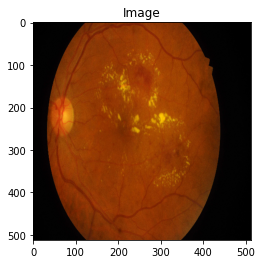

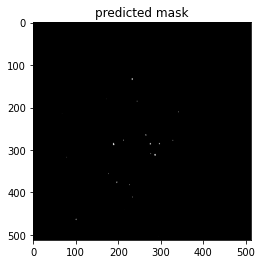

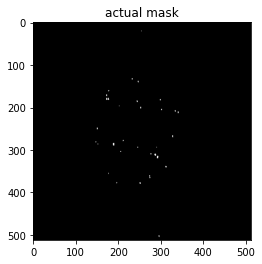

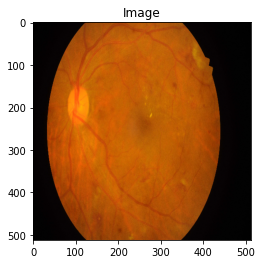

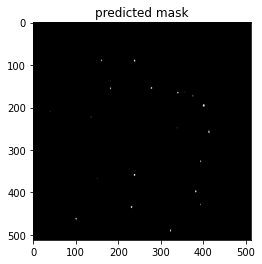

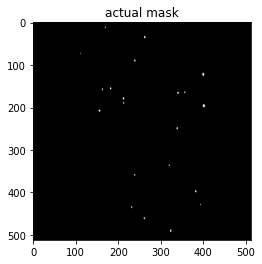

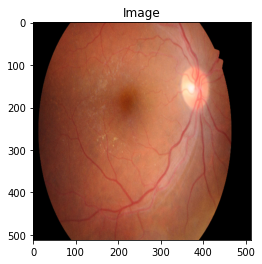

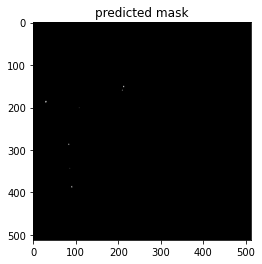

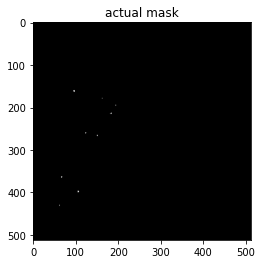

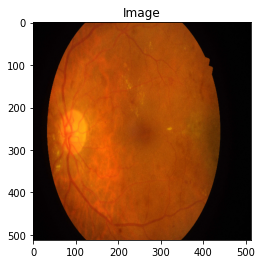

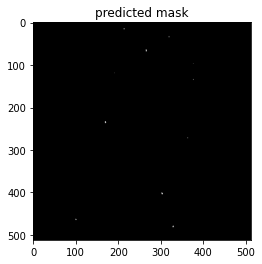

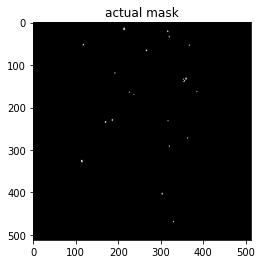

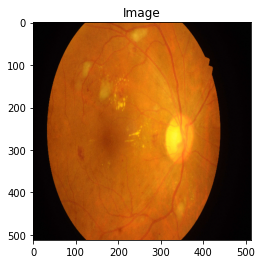

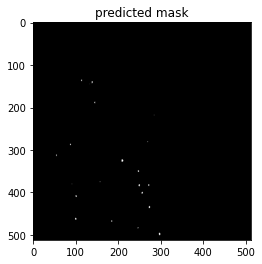

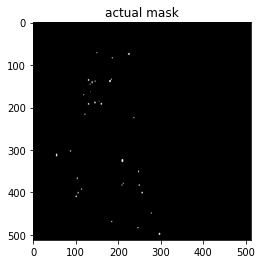

(512, 512, 1)
2. Haemorrhages


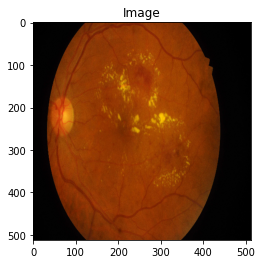

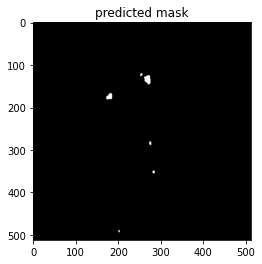

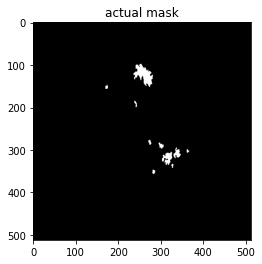

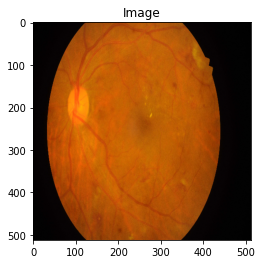

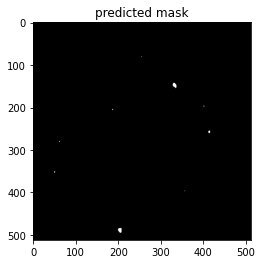

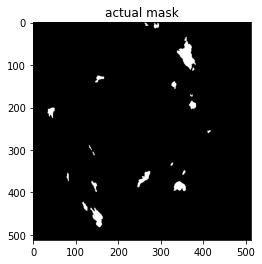

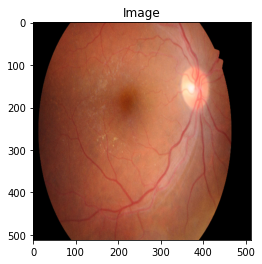

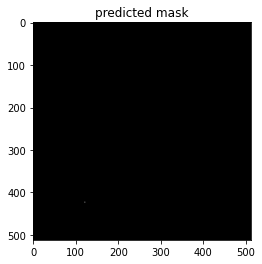

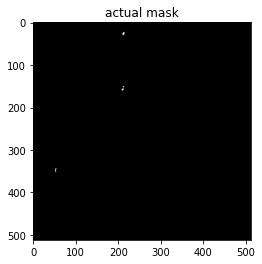

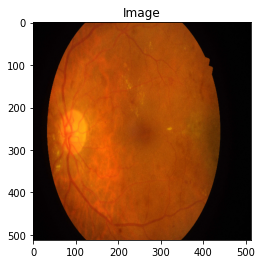

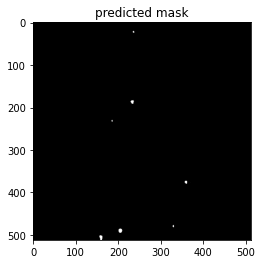

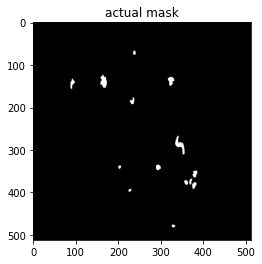

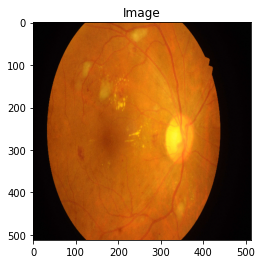

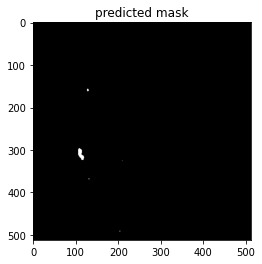

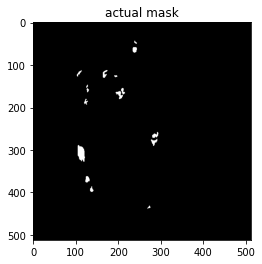

(512, 512, 1)
3. Hard Exudates


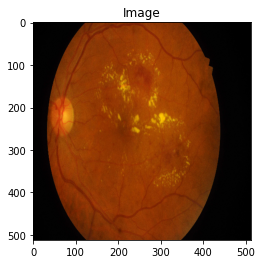

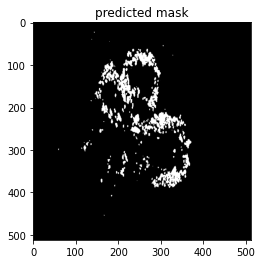

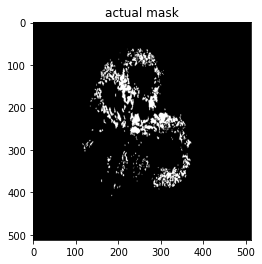

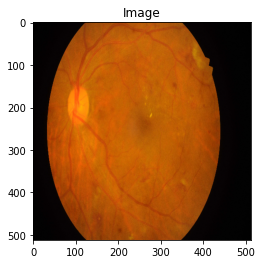

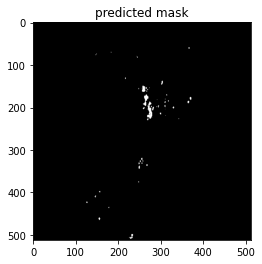

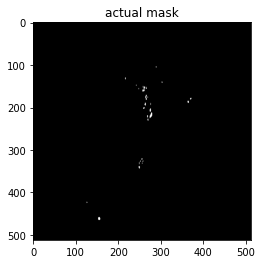

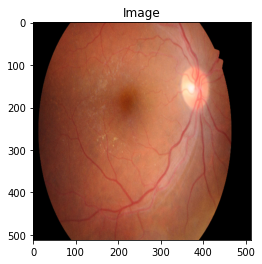

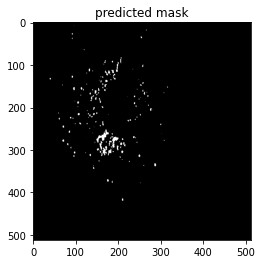

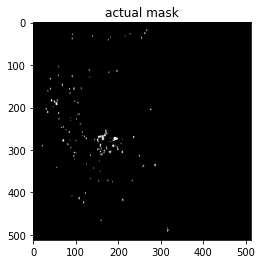

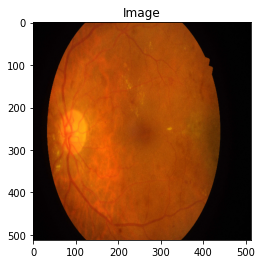

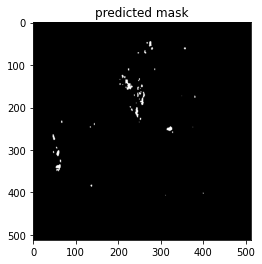

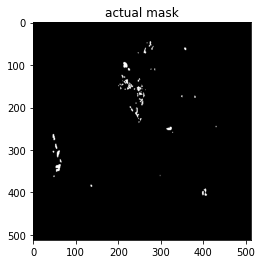

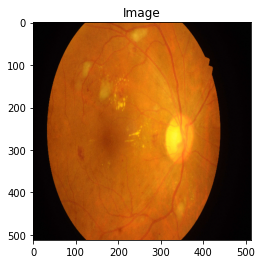

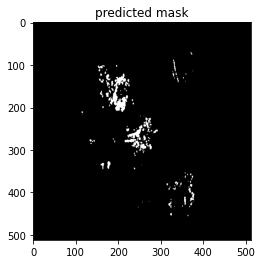

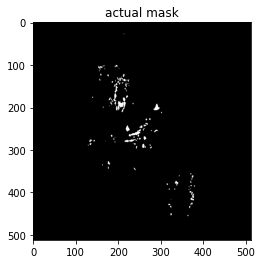

(512, 512, 1)
4. Soft Exudates


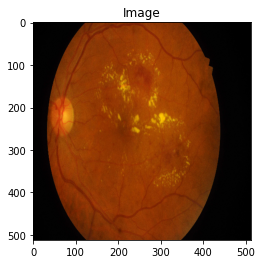

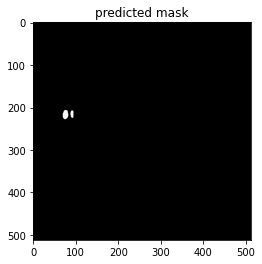

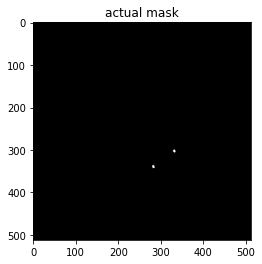

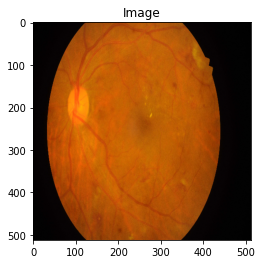

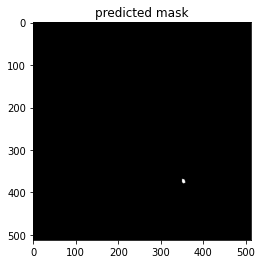

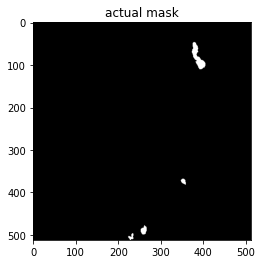

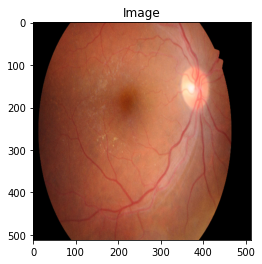

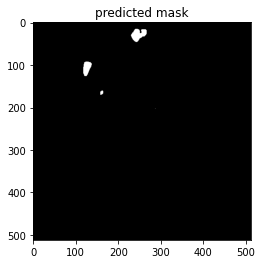

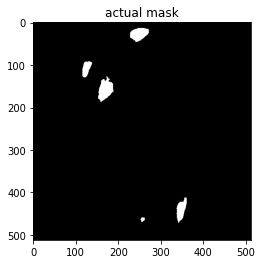

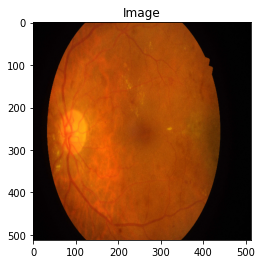

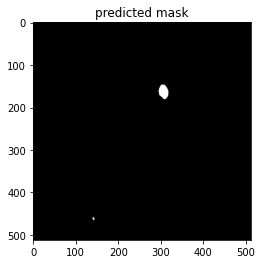

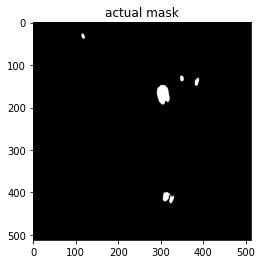

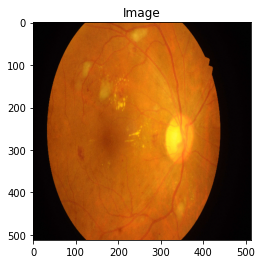

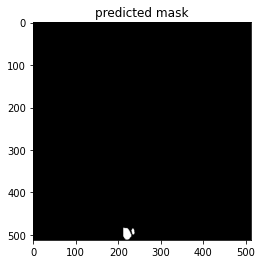

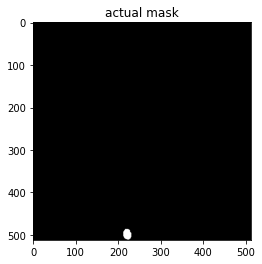

In [60]:
j=0
pred_labels=[]
for model in models:
  if j==3:
    predicted_test_label = model.predict(test_batch_soft);  
  else:
    predicted_test_label = model.predict(test_batch);
  pred_labels.append(predicted_test_label)
  print(predicted_test_label[0].shape)
  print(segs[j])
  
  for i in range(5):
      plt.imshow(test_batch[i,:,:,:])
      plt.title("Image")
      plt.show()
      plt.imshow(np.squeeze(predicted_test_label[i,:,:,:],axis=2),cmap='gray')
      plt.title("predicted mask")
      plt.show()
      plt.imshow(np.squeeze(test_labels_ls[j][i,:,:,:],axis=2),cmap='gray')
      plt.title("actual mask")
      plt.show()
  j+=1

In [65]:
from sklearn.metrics import f1_score
for i in range(4):
  print("type",segs[i])
  testy, yhat_classes=(test_labels_ls[i].reshape(-1),np.round(pred_labels[i].reshape(-1)))
  test_f1 = f1_score(testy, yhat_classes)
  #testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
  #train_f1 = f1_score(testy, yhat_classes)
  train_f1=np.nan
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

type 1. Microaneurysms
Train  F1 score: nan Test F1 score: 0.301382
type 2. Haemorrhages
Train  F1 score: nan Test F1 score: 0.214555
type 3. Hard Exudates
Train  F1 score: nan Test F1 score: 0.609623
type 4. Soft Exudates
Train  F1 score: nan Test F1 score: 0.362129


In [67]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
for i in range(4):
  print("type",segs[i])
  test_aupr = precision_recall_curve(test_labels_ls[i].reshape(-1),pred_labels[i].reshape(-1))
  #train_aupr = precision_recall_curve(train_label.reshape(-1),predicted_train_label.reshape(-1))
  #train_auc=auc(train_aupr[1],train_aupr[0] )
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print(" test AUPR",test_auc)

type 1. Microaneurysms
 test AUPR 0.20181404304725353
type 2. Haemorrhages
 test AUPR 0.14459476983570982
type 3. Hard Exudates
 test AUPR 0.59918897533569
type 4. Soft Exudates
 test AUPR 0.22862379166659047


In [69]:
#serialize and save model 
# serialize model to JSON
j=0
for model in models:
  model_json = model.to_json()
  with open("model_{}.json".format(segs[j]), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("model_{}.h5".format(segs[j]))
  print("Saved model to disk")
  j+=1

Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
